In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import re
from collections import Counter

# === CONFIG ===
API_KEY = "ab393823927f4765b78d2cbaa7bb6fa6"
DICT_PATH = "dictionary.csv"

In [ ]:
# ==NEWSAPI_CREATE==
import requests
import urllib.parse
import pandas as pd
from datetime import datetime, timedelta
import time
import os

query = "S&P 500"
encoded_query = urllib.parse.quote(f'"{query}"')
API_KEY = "YOUR_API_KEY_HERE"
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}
output_file = "newsapi_30_days_full.csv"


def get_news_by_day(query, from_date, to_date, page=1, page_size=100):
    url = (
        f"https://newsapi.org/v2/everything?"
        f"q={query}&from={from_date}&to={to_date}"
        f"&language=en&sortBy=publishedAt"
        f"&page={page}&pageSize={page_size}"
        f"&apiKey={API_KEY}"
    )
    try:
        res = requests.get(url, headers=headers)
        if res.status_code != 200:
          #too much error，has limit within one day. APIkey：ab393823927f4765b78d2cbaa7bb6fa6 or 1d66ef8ddeef4b7c90b270c0d88a35c1
            print(f"❌ Error on {from_date}: {res.status_code}")
            return []

        articles = res.json().get("articles", [])
        results = []
        for a in articles:
            results.append({
                "date": a["publishedAt"][:10],
                "title": a.get("title", ""),
                "description": a.get("description", ""),
                "url": a.get("url", "")
            })
        return results

    except Exception as e:
        print(f"⚠️ Exception on {from_date}: {e}")
        return []

def fetch_news_past_n_days(query, n_days=1):
    today = datetime.today().date() - timedelta(days=1)
    all_articles = []

    for i in range(n_days):
        date = today - timedelta(days=i)
        date_str = date.strftime("%Y-%m-%d")
        print(f"📅 Fetching news for {date_str}...")

        page = 1
        while True:
            articles = get_news_by_day(query, date_str, date_str, page=page)
            if not articles:
                break
            print(f"   📄 Page {page}: {len(articles)} articles")
            all_articles.extend(articles)
            if len(articles) < 100:
                break  # No more pages
            page += 1
            time.sleep(1.2)
        time.sleep(1.5)

    return all_articles


def append_and_deduplicate(new_data, file_path):
    new_df = pd.DataFrame(new_data)
    if new_df.empty:
        print("⚠️ No new data fetched.")
        return pd.DataFrame()

    if os.path.exists(file_path):
        old_df = pd.read_csv(file_path)
        df_news = pd.concat([old_df, new_df], ignore_index=True)
        df_news.drop_duplicates(subset=["title", "url"], keep="last", inplace=True)
    else:
        df_news = new_df

    df_news.to_csv(file_path, index=False)
    print(f"✅ Appended and saved {len(df_news)} unique articles to {file_path}")
    return df_news


if __name__ == "__main__":
    all_news = fetch_news_past_n_days(encoded_query, n_days=30)  #30 days
    df_news = append_and_deduplicate(all_news, output_file)


📅 Fetching news for 2025-04-25...
❌ Error on 2025-04-25: 401
⚠️ No new data fetched.


In [ ]:
#==SENTIMENT_ANALYSIS==

import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
import pandas as pd




[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:

df = pd.read_csv("newsapi_30_days_full.csv")


df["text"] = df["title"].fillna("") + " " + df["description"].fillna("")


df["vader_score"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])


def classify_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["vader_score"].apply(classify_sentiment)


df.to_csv("newsapi_with_sentiment.csv", index=False)
df.head()

,date,title,description,url,text,vader_score,sentiment_label
0,2025-04-24,Dow Jones Today: Stocks Surge for 3rd Straight...,Dow Jones Today: Stocks Surge for 3rd Straight...,https://slashdot.org/firehose.pl?op=view&amp;i...,Dow Jones Today: Stocks Surge for 3rd Straight...,0.7717,positive
1,2025-04-24,"Stock market today: Dow, S&P 500, Nasdaq futur...",US stock futures held steady after Google pare...,https://finance.yahoo.com/news/live/stock-mark...,"Stock market today: Dow, S&P 500, Nasdaq futur...",0.8225,positive
2,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,NaN,https://biztoc.com/x/e2b8f16341ef38be,S&P 500’s exit from a correction hinged on Tru...,0.0000,neutral
3,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,NaN,https://biztoc.com/x/ad4243735e7fca4f,S&P 500’s exit from a correction hinged on Tru...,0.0000,neutral
4,2025-04-24,S&P 500’s rapid exit from correction territory...,Here’s what the S&P 500 needs to recoup record...,https://www.marketwatch.com/story/s-p-500s-rap...,S&P 500’s rapid exit from correction territory...,-0.3818,negative


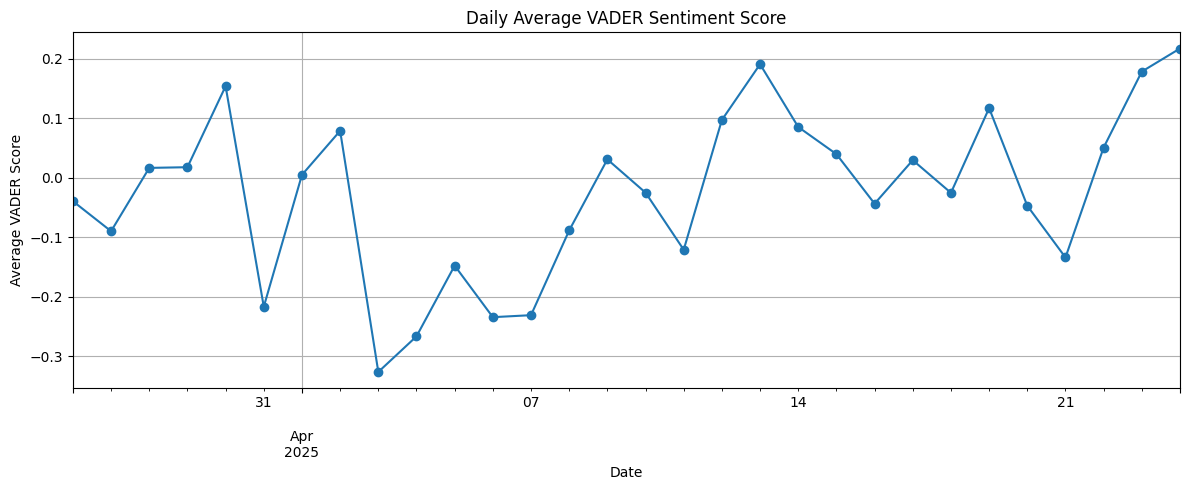

<Figure size 1200x600 with 0 Axes>

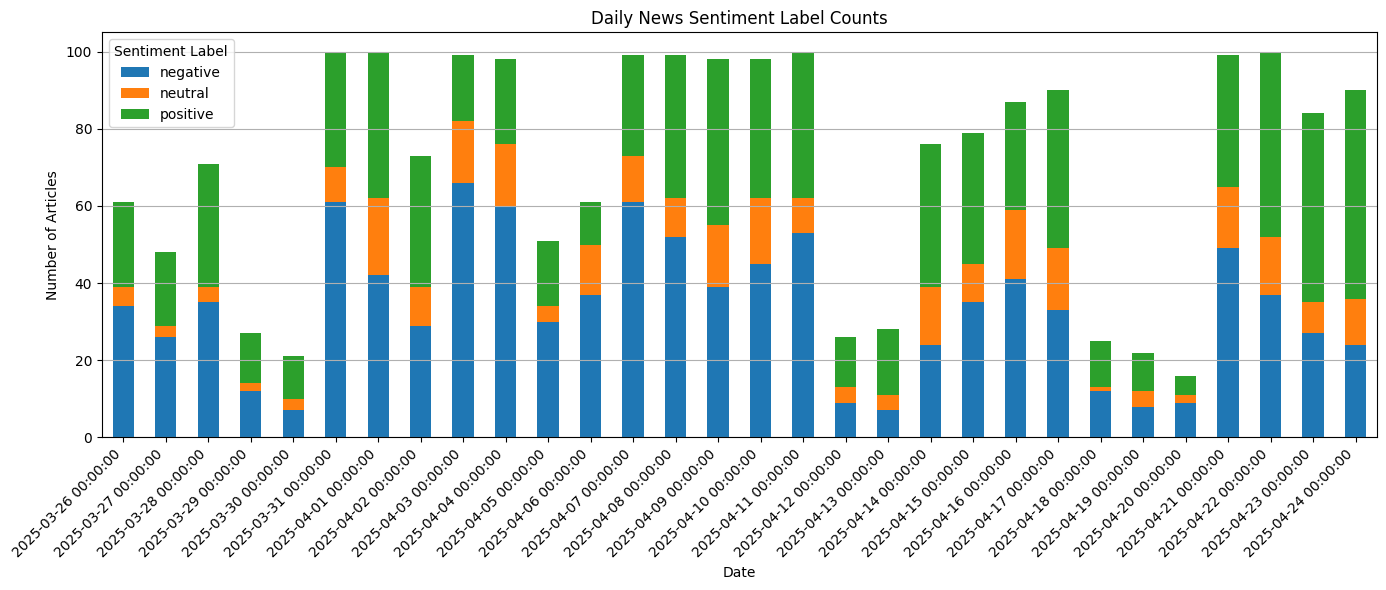

In [ ]:
# ==VISUALIZATION==

import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("newsapi_with_sentiment.csv")


df["date"] = pd.to_datetime(df["date"])


daily_vader_score = df.groupby("date")["vader_score"].mean()

plt.figure(figsize=(12, 5))
daily_vader_score.plot(marker='o')
plt.title("Daily Average VADER Sentiment Score")
plt.ylabel("Average VADER Score")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig("daily_avg_vader_score.png")
plt.show()




daily_sentiment_counts = df.groupby(["date", "sentiment_label"]).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
daily_sentiment_counts.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.title("Daily News Sentiment Label Counts")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y")
plt.legend(title="Sentiment Label")
plt.savefig("daily_sentiment_label.png")
plt.show()


In [ ]:
# ==MACHINE LEARNING==


# Step 1: Mark 'none' as NaN
df["sentiment_label"] = df["sentiment_label"].replace("none", np.nan)

# Step 2: TF-IDF vectorize the content column
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df["text"].fillna(""))

# Step 3: Build train set for KNN
X_known = X_tfidf[~df["sentiment_label"].isna()]
y_known = df.loc[~df["sentiment_label"].isna(), "sentiment_label"]

# Step 4: Fit KNN on known samples
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_known, y_known)

# Step 5: Predict unknown labels only if there are unknowns
if df["sentiment_label"].isna().sum() > 0:
    X_unknown = X_tfidf[df["sentiment_label"].isna()]
    predicted_labels = knn.predict(X_unknown)

    # Step 6: Fill predicted values back into original dataframe
    df.loc[df["sentiment_label"].isna(), "sentiment_label"] = predicted_labels
else:
    print("✅ All sentiment labels are already filled. Skipping prediction.")

# Step 7: Convert to final numeric: positive=1, neutral=0, negative=-1
final_label_map = {"positive": 1, "negative": -1}
df["sentiment_label"] = df["sentiment_label"].map(final_label_map).fillna(0).astype(int)

# Show results
df[["date", "text", "vader_score", "sentiment_label"]].head(10)



✅ All sentiment labels are already filled. Skipping prediction.


,date,text,vader_score,sentiment_label
0,2025-04-24,Dow Jones Today: Stocks Surge for 3rd Straight...,0.7717,1
1,2025-04-24,"Stock market today: Dow, S&P 500, Nasdaq futur...",0.8225,1
2,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,0.0000,0
3,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,0.0000,0
4,2025-04-24,S&P 500’s rapid exit from correction territory...,-0.3818,-1
5,2025-04-24,Wall Street Rallies for a 3rd Straight Day US ...,-0.3612,-1
6,2025-04-24,"Securitize, Mantle launch institutional crypto...",0.1531,1
7,2025-04-24,Gilead Sciences Earnings Were Solid. How the S...,-0.1531,-1
8,2025-04-24,S&P 500 exits correction as U.S. stocks seal 3...,0.5106,1
9,2025-04-24,S&P 500 Exits Correction Territory as Stocks R...,0.2263,1


In [ ]:
sentiment_df = pd.read_csv("newsapi_with_sentiment.csv")
sentiment_df.head()
#'text' combined title and description

,date,title,description,url,text,vader_score,sentiment_label
0,2025-04-24,Dow Jones Today: Stocks Surge for 3rd Straight...,Dow Jones Today: Stocks Surge for 3rd Straight...,https://slashdot.org/firehose.pl?op=view&amp;i...,Dow Jones Today: Stocks Surge for 3rd Straight...,0.7717,positive
1,2025-04-24,"Stock market today: Dow, S&P 500, Nasdaq futur...",US stock futures held steady after Google pare...,https://finance.yahoo.com/news/live/stock-mark...,"Stock market today: Dow, S&P 500, Nasdaq futur...",0.8225,positive
2,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,NaN,https://biztoc.com/x/e2b8f16341ef38be,S&P 500’s exit from a correction hinged on Tru...,0.0000,neutral
3,2025-04-24,S&P 500’s exit from a correction hinged on Tru...,NaN,https://biztoc.com/x/ad4243735e7fca4f,S&P 500’s exit from a correction hinged on Tru...,0.0000,neutral
4,2025-04-24,S&P 500’s rapid exit from correction territory...,Here’s what the S&P 500 needs to recoup record...,https://www.marketwatch.com/story/s-p-500s-rap...,S&P 500’s rapid exit from correction territory...,-0.3818,negative


In [ ]:
# Re-run all steps to ensure full pipeline with train/val/test split

# Vectorize
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(sentiment_df["text"])
y = sentiment_df["sentiment_label"]

# Split train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)

# Store for future trading model reference
dataset_splits = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "vectorizer": vectorizer,
    "df_with_labels": sentiment_df
}




positive (1) → 📈 Buy

zero (0) → ⏸️ Hold / do nothing

negative (-1) → 📉 Sell

In [ ]:
import numpy as np


# Rename label column to match trading signal interpretation
sentiment_df["sentiment_score"] = sentiment_df["vader_score"].apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)


# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(sentiment_df["text"])
y = sentiment_df["sentiment_score"]

# Train/Val/Test split (60/20/20)
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)


# Check class distribution
train_dist = dict(Counter(y_train))
val_dist = dict(Counter(y_val))
test_dist = dict(Counter(y_test))

dist_summary = pd.DataFrame({
    "Train": pd.Series(train_dist),
    "Validation": pd.Series(val_dist),
    "Test": pd.Series(test_dist)
}).fillna(0).astype(int)

dist_summary.index.name = "Signal"
dist_summary.reset_index(inplace=True)


dist_summary


,Signal,Train,Validation,Test
0,-1,608,203,203
1,0,163,54,55
2,1,504,168,168


In [ ]:
# Train logistic regression for multiclass classification (Buy / Hold / Sell)
logit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

# Predict on validation and test
y_val_pred = logit_model.predict(X_val)
y_test_pred = logit_model.predict(X_test)

# Evaluation
val_report = classification_report(y_val, y_val_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

val_df = pd.DataFrame(val_report).T
test_df = pd.DataFrame(test_report).T

val_df


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,precision,recall,f1-score,support
-1,0.692946,0.822660,0.752252,203.000000
0,0.875000,0.129630,0.225806,54.000000
1,0.693182,0.726190,0.709302,168.000000
accuracy,0.696471,0.696471,0.696471,0.696471
macro avg,0.753709,0.559493,0.562454,425.000000
weighted avg,0.716171,0.696471,0.668385,425.000000


To predict the sentiment(-1, 0, 1) of a news article using its text.

Detect and evaluate which machine learning model is the most suitable for predicting sentiment labels based on text features

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Step 1: Try multiple models on train, evaluate on val
models = {
    "LogisticRegression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "MultinomialNB": MultinomialNB()
}

val_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred, average='weighted')
    val_scores[name] = score

# Step 2: Pick best model based on val F1-score
best_model_name = max(val_scores, key=val_scores.get)
best_model = models[best_model_name]

# Step 3: Retrain on train+val
X_train_full = X_trainval
y_train_full = y_trainval
best_model.fit(X_train_full, y_train_full)

# Step 4: Evaluate on test
y_test_pred = best_model.predict(X_test)
final_report = classification_report(y_test, y_test_pred, output_dict=True)

final_report = pd.DataFrame(final_report).T
final_report


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,precision,recall,f1-score,support
-1,0.810056,0.714286,0.759162,203.0000
0,0.488372,0.763636,0.595745,55.0000
1,0.763975,0.732143,0.747720,168.0000
accuracy,0.727700,0.727700,0.727700,0.7277
macro avg,0.687468,0.736688,0.700876,426.0000
weighted avg,0.750351,0.727700,0.733551,426.0000


In [ ]:
best_model_name

'LogisticRegression'